In [9]:
import numpy as np
import astropy.io as fits
import os
import disk as d
import matplotlib.pyplot as plt
import gaussian as g

def apphot(image, mask, apr_radius, rin, rout, centre):
    """
    Performs Aperture photometry calculations on a given image

    Parametrs:
    ----------
    - image( 2d numpy array ): input image containing the object
    - mask( 2d numpy array of bools) : mask over the image that shows good and bad pixels
    - apr_radius (float): Aperture radius for photometry
    - rin (float): inner radius of the sky annulus
    - rout (float): outer radius of the sky annulus
    - centre (tuple): (y,x )coordinates of centre of the object in the image

    Returns:
    ---------
    -tuple: (stellar flux, average sky, bad_pixel_count)    
        - stellar_flux (float): Total flux in the aperture after sky subtraction.
        - average_sky (float): Mean sky background value per pixel.
        - bad_pixel_count (int): Number of bad pixels within the aperture.
    """
    #a)
    y0 , x0 = centre
    sub_image = image[int(y0-rout-1):int(y0+rout+1) , int(x0-rout-1):int(x0+rout+1)]
    sub_mask = mask[int(y0-rout-1):int(y0+rout+1) , int(x0-rout-1):int(x0+rout+1)]
    
    #b)
    skymask = d.disk(rout, centre, sub_image.shape) \
                ^ d.disk(rin,  centre, sub_image.shape)
    valid_sky = skymask & sub_mask  #excluding bad pixels  
    
    #c)
    average_sky  = np.median( sub_image[valid_sky] )

    #d)
    sky_subtracted_subim = sub_image - average_sky

    #e)    
    aper = d.disk(apr_radius, centre, sub_image.shape)
    valid_aper = aper & sub_mask   #excluding bad pixels
    
    #f)
    flux_aper = np.sum(sky_subtracted_subim[valid_aper]) # total intensity in aperture

    bad_pixel = np.sum( valid_aper & ~sub_mask  ) # in aperture
    
    return flux_aper, average_sky, bad_pixel


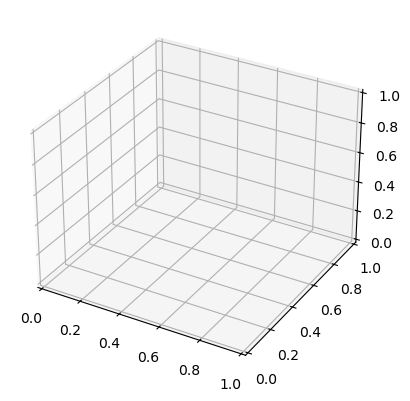

<Figure size 640x480 with 0 Axes>

In [10]:
f3D = 1
fig = plt.figure(f3D)
ax = fig.add_subplot(111, projection='3d')

f2D = 2
im = plt.figure(f2D)

# plotting defaults
cmap = 'summer_r'
rstride = 3
cstride = 3
kwargs = {"cmap":cmap, "rstride":rstride, "cstride":cstride}

# Utility function to put up a 2D and a 3D plot
def show2d3d(im2d, title, f2, f3, ax, x, y, kwargs):
#    figtitle = title.replace(" ", "-")

  # 2D figure
    plt.figure(f2)
    plt.clf()
    plt.imshow(im2d, origin="lower", interpolation='none')
    #if im2d.dtype != bool:  # colorbar breaks on bool due to deprecated math
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.show()
    
    # 3D figure ; w. fixed bug of apphotdemo.py
    
    
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.plot_surface(x, y, im2d.reshape(x.shape), 
                    cmap = 'YlGnBu')

    ax.set(xticklabels=[],
       yticklabels=[],
       zticklabels=[])

    ax.set_title(title)
    plt.show()

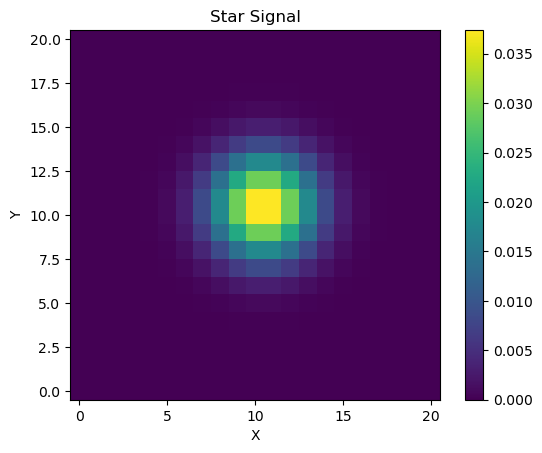

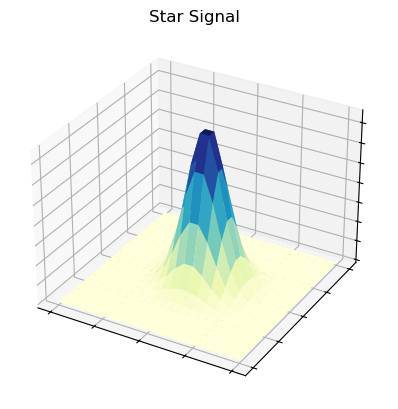

In [14]:
ny,nx = 21,21  #image

#star properties
cy, cx      = ny/2, nx/2
seewidth = 2    #sigma

coo = np.indices((ny, nx))
y, x = coo

# object image with star
starsignal = g.gaussian(coo, (seewidth, seewidth), (cy, cx))
show2d3d(starsignal,  "Star Signal",  f2D, f3D, ax, x, y, kwargs)

# mask with all good pixels
mask = np.ones_like(starsignal, dtype=bool)

In [22]:
data_result = apphot(starsignal, mask, 6, 7, 10, (cy,cx))
print(f'Results \nStellar flux: {data_result[0]:.3f} \nAverage sky: {data_result[1]:.3f}\nBad pixel: {data_result[2]:.3f} ')

Results 
Stellar flux: 0.988 
Average sky: 0.000
Bad pixel: 0.000 


In [ ]:
# we assumed sky level to be 0 and 0 bad pixels as well
#stellar flux is less than one in the given aperture